### Score Normalization
Ref: file:///Users/duane.hinkley/Zotero/storage/H5KPZK4R/score-normilization.html

In [62]:
%run './lib/libraries.ipynb'

dython              0.6.1
tinydb              4.2.0


In [63]:
filterDf = load_df('filterDf')
cats = get_var_cats()

Display scores for assessement_id 748408

In [64]:
filterDf.filter( F.col('assessment_id') == 748408 ).select('learner_assignment_attempt_id', *cats['assignmentAttemptVars']).distinct().toPandas()

,learner_assignment_attempt_id,assessment_instance_attempt_id,assignment_attempt_number,final_score_unweighted,is_force_scored,is_manual_scoring_required,learner_assignment_attempt_id,learner_attempt_status,points_possible_unweighted,scored_datetime,student_start_datetime,student_stop_datetime,was_fully_scored_datetime,was_in_progress_datetime,was_submitted_datetime_actual
0,1002687,1231041,1,38,False,False,1002687,fully scored,48.0,2019-12-13 10:21:57,2019-12-13 17:11:12.994,2019-12-13 18:16:42.211,2019-12-13 18:21:57.891,2019-12-13 17:11:12.994,2019-12-13 18:16:42.211
1,1002584,1148290,1,44,False,False,1002584,fully scored,48.0,2019-12-13 10:17:50,2019-12-13 17:11:19.226,2019-12-13 18:01:39.552,2019-12-13 18:17:51.195,2019-12-13 17:11:19.226,2019-12-13 18:01:39.552
2,1002575,1110794,1,23,False,False,1002575,fully scored,48.0,2020-01-08 07:08:16,2019-12-13 17:11:40.970,2019-12-13 19:49:42.369,2020-01-08 15:08:16.987,2019-12-13 17:11:40.970,2019-12-13 19:49:42.369
3,1002702,1227978,1,32,False,False,1002702,fully scored,48.0,2020-01-09 09:59:44,2019-12-13 17:11:20.474,2019-12-13 19:49:09.331,2020-01-09 17:59:44.637,2019-12-13 17:11:20.474,2019-12-13 19:49:09.331
4,1002648,1155442,1,46,False,False,1002648,fully scored,48.0,2019-12-13 10:23:15,2019-12-13 17:10:29.972,2019-12-13 18:12:21.236,2019-12-13 18:23:15.737,2019-12-13 17:10:29.972,2019-12-13 18:12:21.236
5,1002598,1098979,1,39,False,False,1002598,fully scored,48.0,2020-01-08 07:03:42,2019-12-11 19:28:13.214,2019-12-13 18:15:09.274,2020-01-08 15:03:42.000,2019-12-11 19:28:13.214,2019-12-13 18:15:09.274
6,1002614,1122674,1,40,False,False,1002614,fully scored,48.0,2020-01-08 07:01:42,2019-12-12 18:16:15.273,2019-12-13 18:16:09.253,2020-01-08 15:01:42.000,2019-12-12 18:16:15.273,2019-12-13 18:16:09.253
7,1002831,1175820,1,44,False,False,1002831,fully scored,48.0,2020-01-08 07:05:32,2019-12-13 17:12:22.668,2019-12-13 18:16:44.329,2020-01-08 15:05:32.722,2019-12-13 17:12:22.668,2019-12-13 18:16:44.329
8,1002637,1117904,1,43,False,False,1002637,fully scored,48.0,2020-01-09 09:37:13,2019-12-13 17:12:22.130,2019-12-13 18:12:51.117,2020-01-09 17:28:08.000,2019-12-13 17:12:22.130,2019-12-13 18:12:51.117
9,1002558,1190008,1,44,False,False,1002558,fully scored,48.0,2019-12-13 09:53:22,2019-12-13 17:10:04.346,2019-12-13 17:35:40.186,2019-12-13 17:53:22.357,2019-12-13 17:10:04.346,2019-12-13 17:35:40.186


Formula:

Z=(X-M)/S
z refers to the z-score,
M is the estimate of the population's mean,
S is the estimate of the population's standard deviation,
X is an individual score within the distribution having mean M and variance S.

mean and standard deviation

In [65]:
s = (filterDf.groupBy("assessment_id")
  .agg(
      F.stddev_pop("final_score_unweighted").alias("sd"),
      F.avg("final_score_unweighted").alias("avg")))

s.show()

+-------------+------------------+------------------+
|assessment_id|                sd|               avg|
+-------------+------------------+------------------+
|       748408|  9.70285157671306|  36.1764705882353|
|       661489|3.9049807722146905| 4.016835016835016|
|       699380|               0.0|               2.0|
|       756753|1.0657453489407904| 9.264705882352942|
|       687644| 4.712120714991611|11.285714285714286|
|       696973|0.8164965809277269|              32.0|
|       653848|               0.0|               4.0|
|       722540|0.4330127018922194|             14.75|
|       729577|0.8984743935292004|2.0476190476190474|
|       725646|               0.0|               2.0|
|       721940| 5.990939661246087|12.444444444444445|
|       694324|               0.0|               3.0|
|       740994|               0.0|               5.0|
|       740960|               0.0|              14.0|
|       756773|0.6428243465332258| 9.363636363636363|
|       654733|             

Normalized score

In [66]:
filterDf.join(F.broadcast(s), ["assessment_id"])

(filterDf
    .join(F.broadcast(s), ["assessment_id"])
    .select(
        "assessment_id",
        "final_score_unweighted",
        ((filterDf.final_score_unweighted - s.avg) / s.sd).alias('score')
)).show()

+-------------+----------------------+-------------------+
|assessment_id|final_score_unweighted|              score|
+-------------+----------------------+-------------------+
|       736105|                     3| 0.8806960340770612|
|       727353|                    10|  0.872730216669552|
|       727353|                    10|  0.872730216669552|
|       732131|                    18| 0.8248550491389584|
|       732131|                    18| 0.8248550491389584|
|       732131|                    18| 0.8248550491389584|
|       736105|                     3| 0.8806960340770612|
|       727353|                    10|  0.872730216669552|
|       736105|                     3| 0.8806960340770612|
|       736105|                     3| 0.8806960340770612|
|       732131|                    18| 0.8248550491389584|
|       732131|                    18| 0.8248550491389584|
|       724303|                     7|-0.7874007874011821|
|       732131|                    18| 0.824855049138958

In [73]:
from scipy import stats

x = filterDf.join(s, on=['assessment_id'], how='left').select(
        "assessment_id",
        "final_score_unweighted",
        ((filterDf.final_score_unweighted - s.avg) / s.sd * 5).alias('score')
).toPandas()

Is score distribution normal?

In [74]:
from scipy.stats import shapiro

stat, p = shapiro(x.score)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=nan, p=1.000
Sample looks Gaussian (fail to reject H0)


/Users/duane.hinkley/PycharmProjects/c772-capstone-project/venv/lib/python3.6/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


D’Agostino’s K^2 Test

In [75]:
from scipy.stats import normaltest

# normality test
stat, p = normaltest(x.score)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=nan, p=nan
Sample does not look Gaussian (reject H0)


Anderson-Darling Test

In [76]:
from scipy.stats import anderson

# normality test
result = anderson(x.score)
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
	sl, cv = result.significance_level[i], result.critical_values[i]
	if result.statistic < result.critical_values[i]:
		print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
	else:
		print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

Statistic: nan
15.000: 0.576, data does not look normal (reject H0)
10.000: 0.656, data does not look normal (reject H0)
5.000: 0.787, data does not look normal (reject H0)
2.500: 0.918, data does not look normal (reject H0)
1.000: 1.092, data does not look normal (reject H0)


QQ Plot of scores

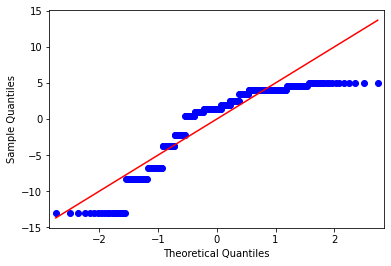

In [77]:
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot

# q-q plot
qqplot(x[ x['assessment_id'] == 748408 ].score, line='s')
pyplot.show()

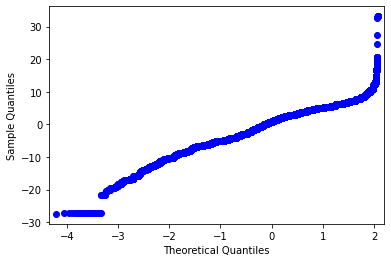

In [79]:
# q-q plot
qqplot(x.score, line='s')
pyplot.show()

histogram of scores

array([[<AxesSubplot:title={'center':'score'}>]], dtype=object)

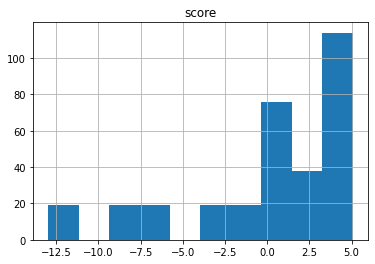

In [80]:
x[ x['assessment_id'] == 748408 ].hist('score')